In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/20202/Computer Vision/Project1

Mounted at /content/drive
/content/drive/MyDrive/20202/Computer Vision/Project1


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# **1. Ảnh hạt gạo**




In [ ]:
# lableing
def labeling(og_img, contours):

    for idx, cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        # add a red dot at center contours
        cv2.circle(og_img, (x+int(w/2),y+int(h/2)), radius=0, color=(255, 0, 0), thickness=3)
        # cv2.rectangle(og_img, (x, y), (x+w, y+h), (255, 0, 0), 1)
        # put index contours
        # cv2.putText(og_img, str(idx+1), (x+int(w/2) + 1, y+int(h/2) + 1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),1)

    return og_img

In [ ]:
def count_rice(img_path, gamma_origin=0, size_medianBlur=3, threshold_mag=0.8, r=5, 
               size_gaussianBlur=5, sigma=0, method_extract=cv2.RETR_EXTERNAL, method_appro=cv2.CHAIN_APPROX_SIMPLE,
               threshold_area=10, noise_periodic=0, gamma_post=0.16,adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
               thresholdType=cv2.THRESH_BINARY, blockSize=49, C=-20, kernel_erode=5):
  '''
  :img_path: 
    đường dẫn tới ảnh
  :gamma_origin: 
    hệ số gamma để thực hiện power-law transformations với ảnh đầu vào, chỉ thực
    hiện nếu gamma > 0
  :size_medianBlur:
    kích thước filter để thực hiện median blur (loại bỏ nhiễu muối tiêu)
  :threshold_mag: 
    ngưỡng giá trị để lấy ra vị trí các điểm sáng nhất của ảnh trong miền tần số
  :r: 
    bán kính từ điểm trung tâm của ảnh trong miền tần số, các điểm ảnh sáng nhất 
    nằm ngoài bán kính này được coi là nhiểu và sẽ bị loại bỏ
  :size_gaussianBlur: 
    kích thước filter để thực hiện giảm nhiều Gauss
  :sigma: 
    độ lệch chuẩn theo hai hướng x, y khi thực hiện giảm nhiểu Gauss, nếu đặt 
    bằng 0, sẽ được tính toán từ size_gaussianBlur
  :method_extract:
    phương pháp trích xuất contour
  :method_appro:
    phương pháp xấp xỉ contour
  :threshold_area:
    ngưỡng diện tích được xem là một object trong ảnh
  :noise_periodic:
    ảnh có nhiễu sin/cos không
  :gamma_post:
    hệ số gamma để thực hiện power-law transformations sau một loạt các bước xử
    lý trên ảnh đầu vào
  :adaptiveMethod:
    phương pháp nhị phân hóa với ngưỡng động
  :thresholdType:
    kiểu nhị phân
  :blockSize:
    kích thước vùng lân cận thực hiện lấy ngưỡng động
  :C:
    hằng số [-255, 255]
  :kernel_erode:
    kích thước kernel để thực hiện erode
  '''
  img_origin = cv2.imread(img_path, 0)
  img = img_origin.copy()

  # loại bỏ nhiễu muối tiêu
  img = cv2.medianBlur(img, size_medianBlur)
  # plt.imshow(img, cmap='gray')

  # tăng cường độ tương phản
  if gamma_origin > 0:
    img = np.array(255*(img/255)**gamma_origin, dtype='uint8')
  img_return = img

  if noise_periodic == 1:
    # Ảnh đầu vào phải là ảnh xám
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    # Dịch tọa độ 0,0 vào giữa
    dft_shift = np.fft.fftshift(dft)

    # lấy độ lớn và pha
    mag, phase = cv2.cartToPolar(dft_shift[:,:,0], dft_shift[:,:,1])
    mag = 20*np.log(mag)
    mag = mag / mag.max()
    mask = (mag > threshold_mag).astype(np.uint8)

    rows, cols = img.shape
    crow, ccol = rows//2 , cols//2
    mask[crow-r:crow+r, ccol-r:ccol+r] = 0

    dft_shift[mask != 0] = 0

    f_ishift = np.fft.ifftshift(dft_shift) # dịch lại tọa độ 0,0 về góc trên bên trái
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1]) # ảnh sau khi đã iDFT
    img_back = np.array(255*(img_back/255)**gamma_post, dtype='uint8')
    img_return = img_back
  
  th = cv2.adaptiveThreshold(img_return, 255, adaptiveMethod, thresholdType, blockSize, C)
  kernel_erosion = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_erode, kernel_erode))
  img_contour = cv2.erode(th, kernel_erosion)

  # Tìm contours
  contours, hierarchy = cv2.findContours(img_contour, method_extract, method_appro)
  contour_select = [contour for contour in contours if cv2.contourArea(contour)>=threshold_area]
  
  img_draw = img_return.copy()
  img_draw = cv2.cvtColor(img_draw, cv2.COLOR_GRAY2RGB)
  cv2.drawContours(img_draw, contour_select, -1, (0, 255, 0), 2)

  plt.figure(figsize=(24, 8))
  plt.subplot(141)
  plt.imshow(img_origin, cmap = 'gray')
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(142)
  plt.imshow(img_return, cmap = 'gray')
  plt.title('Image postprocess'), plt.xticks([]), plt.yticks([])

  plt.subplot(143)
  plt.imshow(img_contour, cmap = 'gray')
  plt.title('Image after adaptive threshold and erode'), plt.xticks([]), plt.yticks([])

  plt.subplot(144)
  plt.imshow(img_draw)
  plt.title('Contours'), plt.xticks([]), plt.yticks([])
  plt.show()

  print('KẾT QUẢ =================================')
  img_origin = cv2.imread(img_path)
  img_result = labeling(img_origin, contour_select)
  print('Số object trong ảnh: {}'.format(len(contour_select)))
  plt.figure(figsize=(10, 10))
  plt.imshow(img_result)
  plt.title('Result'), plt.xticks([]), plt.yticks([])
  plt.show()


# **RUN**

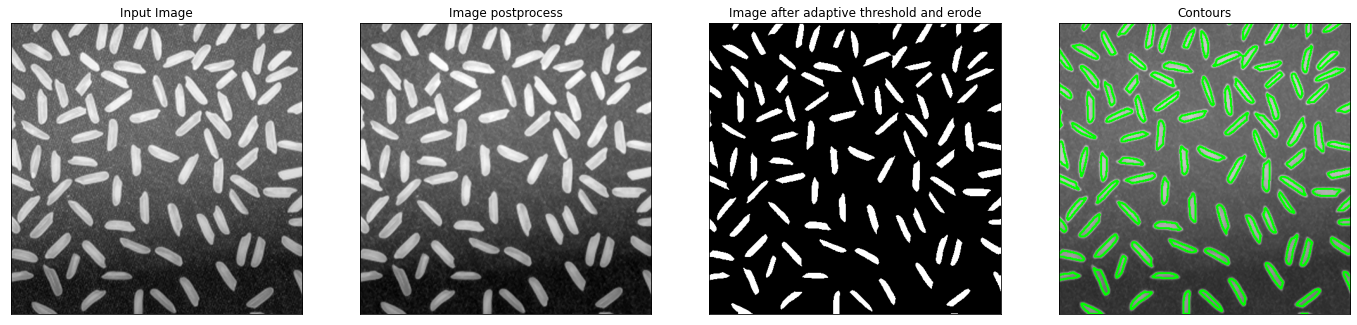

KẾT QUẢ =================================
Số object trong ảnh: 100


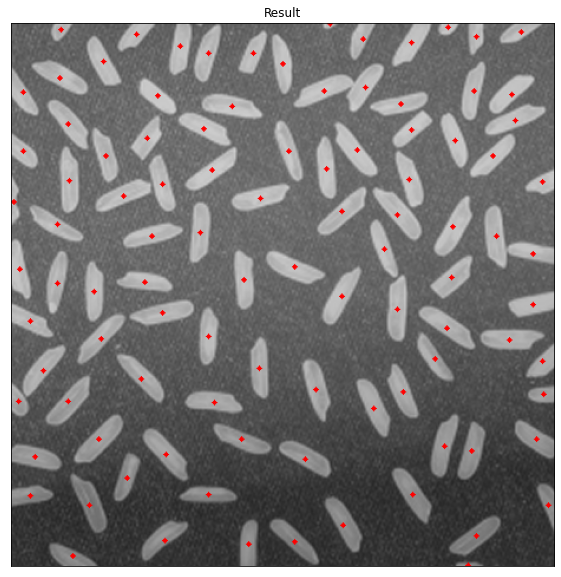

In [ ]:
img_path = './data/rice1.png'
count_rice(img_path, gamma_origin=0, threshold_area=0, noise_periodic=0, kernel_erode=5)

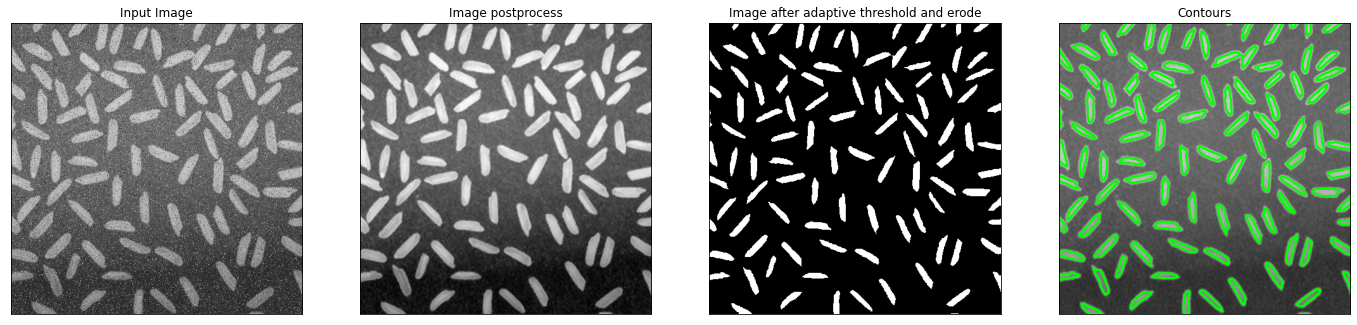

KẾT QUẢ =================================
Số object trong ảnh: 100


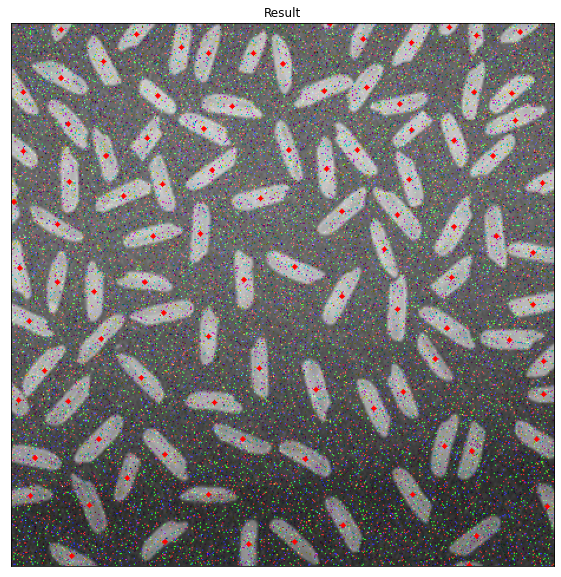

In [ ]:
img_path = './data/rice2.png'
count_rice(img_path, gamma_origin=0, threshold_area=0)

In [ ]:
img_path = './data/rice3.png'
count_rice(img_path, gamma_origin=0, threshold_area=0, noise_periodic=1, r=5, threshold_mag=0.8)

KẾT QUẢ =================================
Số object trong ảnh: 100


KẾT QUẢ =================================
Số object trong ảnh: 99


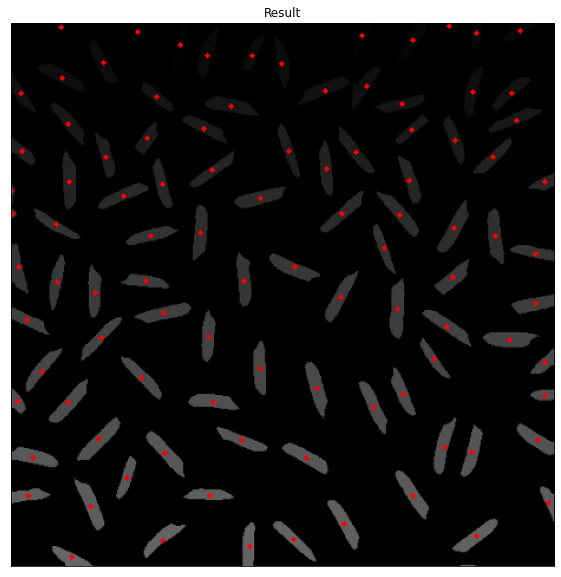

In [ ]:
img_path = './data/rice4.png'
count_rice(img_path, gamma_origin=0.2, threshold_area=0, noise_periodic=0) #, method_appro= cv2.CHAIN_APPROX_NONE

# **2. Ảnh đồ vật văn phòng**


In [ ]:
# lableing
def labeling(og_img, contours):

    for idx, cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        # add a red dot at center contours
        cv2.circle(og_img, (x+int(w/2),y+int(h/2)), radius=0, color=(0, 0, 255), thickness=3)
        cv2.rectangle(og_img, (x, y), (x+w, y+h), (255, 0, 0), 1)
        # put index contours
        cv2.putText(og_img, str(idx+1), (x+int(w/2) + 1, y+int(h/2) + 1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0),2)

        

    return idx+1, og_img

In [ ]:
def count_office(img_path, threshold_area, blockSize=255, C=19, kernel_erode=13, kernel_dilate=15,
           size_medianBlur=7, method_extract=cv2.RETR_EXTERNAL, method_appro=cv2.CHAIN_APPROX_SIMPLE,
           adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv2.THRESH_BINARY_INV, gamma=1.2):
  '''
  :img_path:
    đường dẫn đến ảnh
  :threshold_area:
    ngưỡng diện tích để xác định là một đối tượng trong ảnh
  :adaptiveMethod:
    phương pháp lấy ngưỡng động
  :thresholdType:
    kiểu lấy ngưỡng
  :blockSize:
    kích thước vùng lân cận thực hiện lấy ngưỡng động
  :C:
    hằng số [-255, 255]
  :kernel_erode:
    kích thước kernel để thực hiện erode
  :kernel_dilate:
    kích thước kernel để thực hiện dilate
  :size_medianBlur:
    kích thước filter để thực hiện median blur (loại bỏ nhiễu muối tiêu)
  :method_extract:
    phương pháp trích xuất contour
  :method_appro:
    phương pháp xấp xỉ contour
  :gamma: 
    hệ số gamma để thực hiện power-law transformations với ảnh đầu vào
  '''

  img_origin = cv2.imread(img_path)
  img = cv2.cvtColor(img_origin, cv2.COLOR_BGR2GRAY)

  # Tăng độ tương phản và thực hiện nhị phân hóa theo ngưỡng động
  img_contrast = np.array(255 * (img / 255) ** gamma , dtype='uint8')
  img_th = cv2.adaptiveThreshold(img_contrast, 255, adaptiveMethod, thresholdType, blockSize, C)

  # Thực hiện dilation và erosion
  kernel_1 = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_dilate, kernel_dilate))
  kernel_2 = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_erode, kernel_erode))

  img_dilate = cv2.dilate(img_th, kernel_1, iterations=1)
  img_erode = cv2.erode(img_dilate, kernel_2, iterations=1)

  # Loại bỏ nhiễu muối tiêu
  img_remove_noise = cv2.medianBlur(img_erode, size_medianBlur)

  # Tìm contours, lọc contours theo ngưỡng diện tích
  contours, hierarchy = cv2.findContours(img_remove_noise, method_extract, method_appro)
  contour_select = [contour for contour in contours if cv2.contourArea(contour)>=threshold_area]

  img_draw = img.copy()
  img_draw = cv2.cvtColor(img_draw, cv2.COLOR_GRAY2RGB)
  cv2.drawContours(img_draw, contour_select, -1, (255, 255, 0), 3)


  plt.figure(figsize=(24, 8))
  plt.subplot(241)
  plt.imshow(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB))
  plt.title('Input Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(242)
  plt.imshow(img, cmap='gray')
  plt.title('Image gray'), plt.xticks([]), plt.yticks([])

  plt.subplot(243)
  plt.imshow(img_contrast, cmap='gray')
  plt.title('Image enhance contrast'), plt.xticks([]), plt.yticks([])

  plt.subplot(244)
  plt.imshow(img_th)
  plt.title('Image binary'), plt.xticks([]), plt.yticks([])

  plt.subplot(245)
  plt.imshow(img_dilate)
  plt.title('Image dilate'), plt.xticks([]), plt.yticks([])

  plt.subplot(246)
  plt.imshow(img_erode)
  plt.title('Image erode'), plt.xticks([]), plt.yticks([])

  plt.subplot(247)
  plt.imshow(img_remove_noise)
  plt.title('Image remove noise'), plt.xticks([]), plt.yticks([])

  plt.subplot(248)
  plt.imshow(img_draw)
  plt.title('Image contours'), plt.xticks([]), plt.yticks([])
  plt.show()

  print('KẾT QUẢ =================================')
  num_object, img_result = labeling(img_origin, contour_select)
  print('Số đồ vật phát hiện được: ', num_object)
  plt.figure(figsize=(10, 10))
  plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
  plt.title('Result'), plt.xticks([]), plt.yticks([])
  plt.show()

# **RUN**

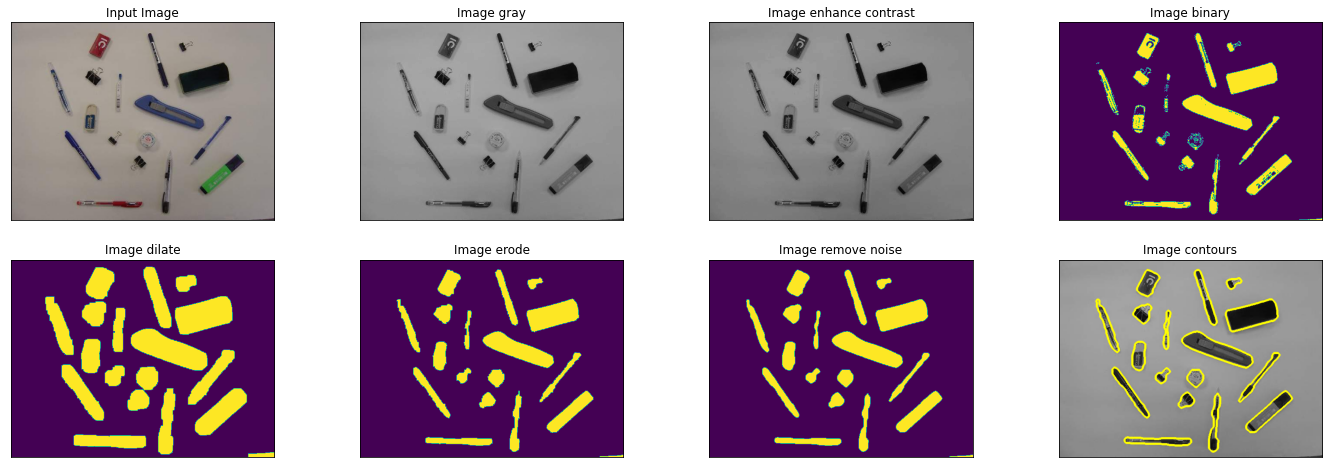

KẾT QUẢ =================================
Số đồ vật phát hiện được:  17


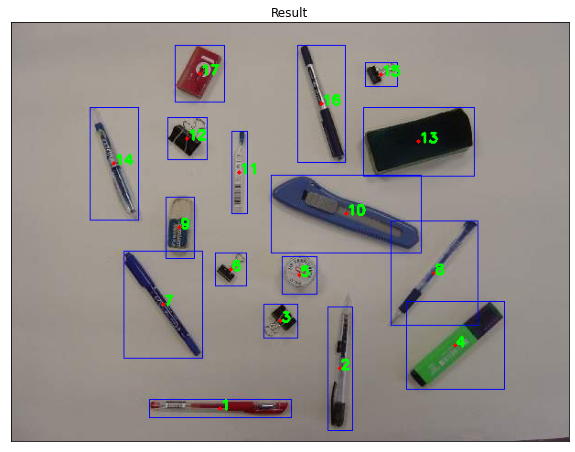

In [ ]:
img_path = './data/objects1.jpg'
count_office(img_path, threshold_area=200, blockSize=255, C=19, gamma=1.2) #cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)

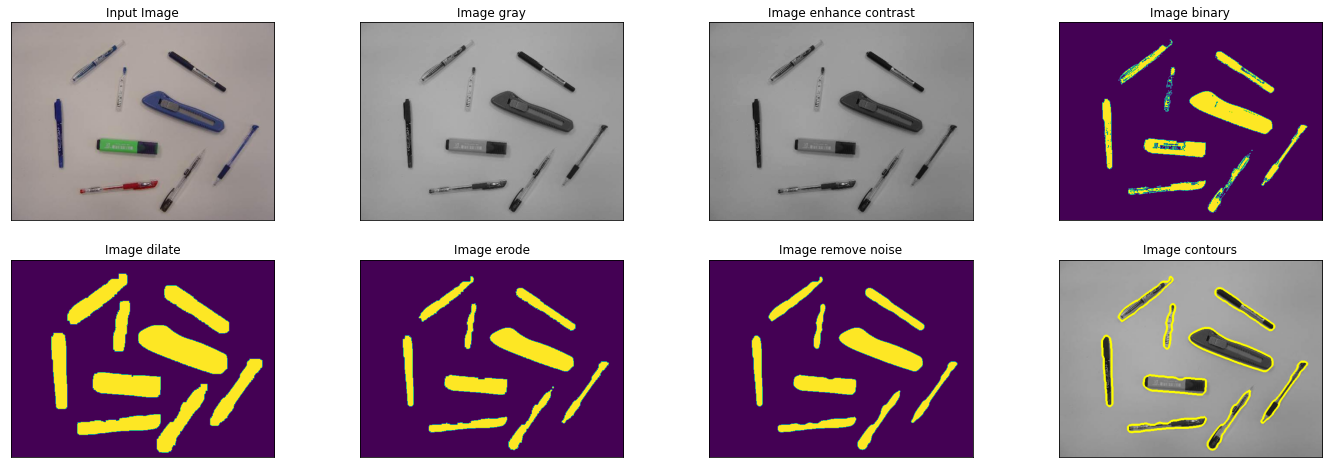

KẾT QUẢ =================================
Số đồ vật phát hiện được:  9


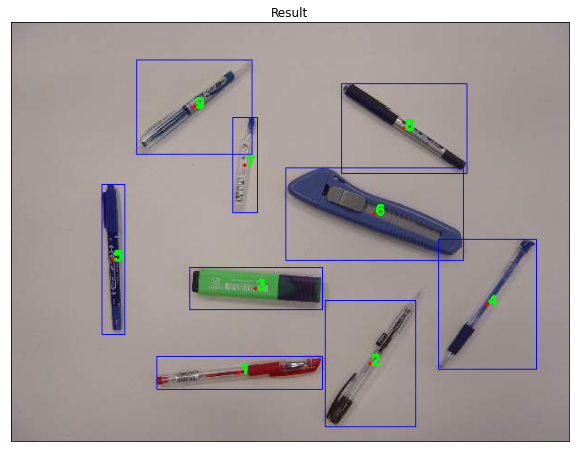

In [ ]:
img_path = './data/objects2.jpg'
count_office(img_path, threshold_area=200, blockSize=255, C=19)

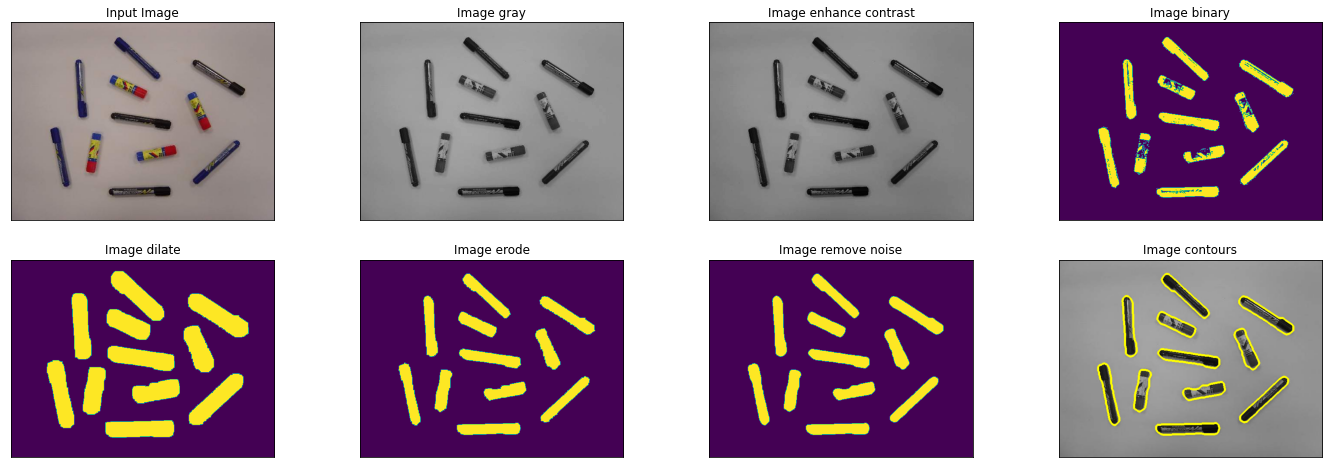

KẾT QUẢ =================================
Số đồ vật phát hiện được:  11


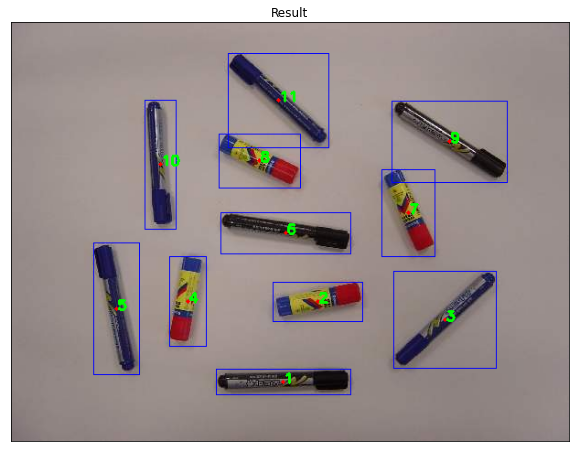

In [ ]:
img_path = './data/objects3.jpg'
count_office(img_path, threshold_area=200, blockSize=255, C=19)

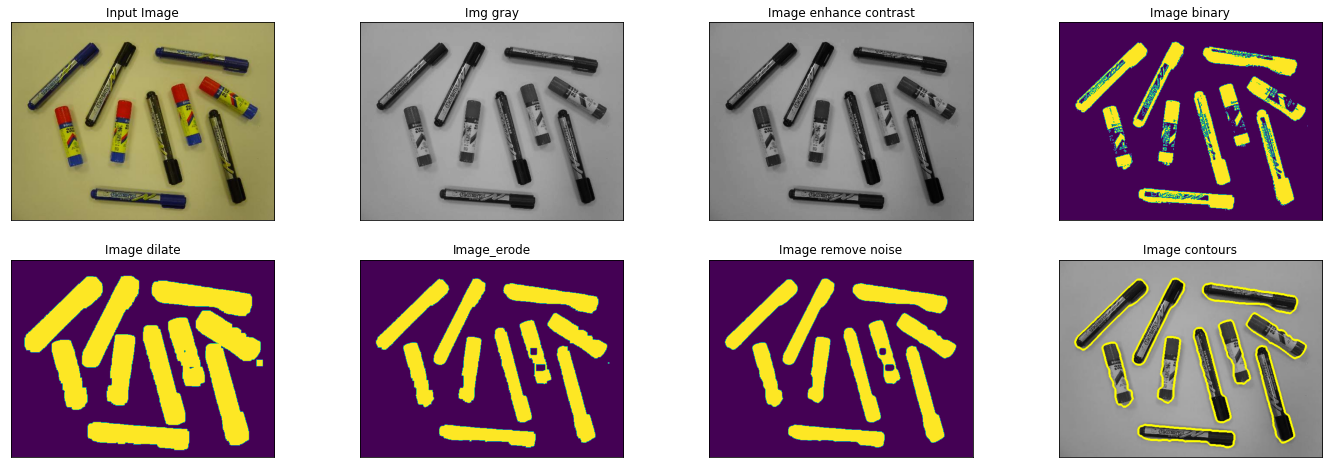

KẾT QUẢ =================================
Số đồ vật phát hiện được:  10


In [ ]:
img_path = './data/objects4.jpg'
count_office(img_path, threshold_area=200, blockSize=255, C=19)